# 5. Investigating Survival/Recurrace
This notebook is fore exploring the connection between survival rate in TNBC and spacial distribution of TILs.

In [242]:
import pandas as pd
from itertools import combinations
import regex as re
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from dataset import TNBC2
import os
sns.set()

In [243]:
df_pred = pd.read_pickle('../data/tnbc2/tnbc.pickle')

In [787]:
df_pat = pd.read_excel('../data/tnbc2/256_TNBC__F_LEION_till_arvid.xlsx')
df_pat["treated"] = df_pat["Type treatment (Adj/Neoadj/Met)"].apply(lambda x: int(x != "None"))
df_pat["dead"] = df_pat["Dead yes 1 no 0"]
df_pat["OS"] = df_pat["OS yes 1 no 0"]
df_pat["IDFS"] = df_pat["IDFS yes 1 no 0"]
df_pat["DRFI"] = df_pat["DRFI Breast cancer spec"]
df_pat["relapse"] = df_pat["Relapse yes 1 no 0"]
df_pat.columns

Index(['TMAid', 'TILs helsnitt', 'TILs TMA',
       'Patient SCANB research (external) ID', 'Age at diagnosis',
       'Histological diagnosis', 'Size (mm)', 'Positive nodes', 'Total nodes',
       'T', 'N', 'Histological grade', 'ER', 'PR', 'HER2', 'Ki67',
       'Type treatment (Adj/Neoadj/Met)', 'Chemo (schema)', 'RT(schema)',
       'Endocrine treatment', 'Date of diagnosis', 'Relapse (yes/no)',
       'Relapse yes 1 no 0', 'Date of relapse', 'Relapse site', 'Death',
       'Dead yes 1 no 0', 'Date of death', 'Last follow-up',
       'Time to followup', 'Time to relaps', 'Time to death',
       'Date of surgery', 'OS yes 1 no 0', 'IDFS yes 1 no 0',
       'DRFI Breast cancer spec', 'Date_event_OS',
       'Date_Event_IDFS_dead_relapse', 'Date_IDFS', 'TMA-id', 'DRFI_months',
       'Months_surgery_distant_relapse', 'Months_surgery_death',
       'Months_surgery_FU', 'Months_adjuvant_OS', 'Months_untreat_OS',
       'treated', 'dead', 'OS', 'IDFS', 'DRFI', 'relapse'],
      dtype='ob

In [245]:
def ripleys_k(locations, t=50):
    """en.wikipedia.org/wiki/Spatial_descriptive_statistics#Ripley.27s_K_and_L_functions"""
    
    n = len(locations)
    within_t = 0
    z = np.array([[complex(x, y) for x, y in locations]])
    distances = abs(z.T-z)
    within_t = np.sum(distances[0] < t)
        
    return np.sqrt(within_t / n)

def _patient_id(image_name):
    block,  nr, letter = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", image_name)[0]
    block_start = [1, 59, 113, 172, 210]
    start = block_start[int(block)-1]
    
    letter = letter.lower()
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    pat_id = key[int(nr)-1][11 - (ord(letter) - 97)]
    return pat_id
    
def _tma_id(patient_id):
    block_start = [1, 59, 113, 172, 210]
    start = [s for s in block_start if patient_id >= s][-1]
    block = block_start.index(start) + 1
            
    key = np.array([i for i in range(start, start + int(10*12/2)) for n in range(2)]).reshape((10,12))
    Y, X = np.where(key == patient_id) 
    letters = [chr(11 - (x - 97)).upper() for x in X]
    numbers = list(Y + 1)
    return block, letters, numbers
    
def _image_path(patient_id):
    block, letters, numbers = _tma_id(patient_id)
    paths = []
    dataset = TNBC2()
    for let, num in zip(letters, numbers):
        for file in os.listdir(dataset.image_dir):
            b, n, l = re.findall(r"Block_(\d).*_(.*)_([A-Z])_", file)[0]
            if int(b) == block and int(n) == num and l == let:
                paths.append(dataset.image_dir / file)
    return paths

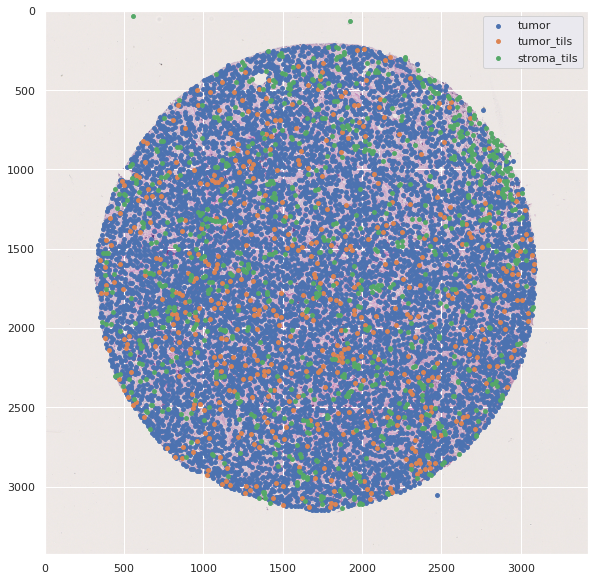

In [736]:
from scipy.spatial import distance

def tumor_stroma_tils(immune_loc, tumor_loc, r=20, factor=1.5):
    tumor_loc = np.array([list(coord) for coord in tumor_loc])
    immune_loc = np.array([list(coord) for coord in immune_loc])
    
    tumor_dist = distance.cdist(tumor_loc,immune_loc)
    immune_dist = distance.cdist(immune_loc,immune_loc)
    
    tumor_within_r = tumor_dist < r
    immune_within_r = immune_dist < r
    
    n_tumor_within = tumor_within_r.sum(axis=0)
    n_immune_within = immune_within_r.sum(axis=0)
    
    tumor_tils = n_tumor_within > n_immune_within*1.5
    stroma_tils = n_tumor_within*1.5 < n_immune_within

    return immune_loc[tumor_tils], immune_loc[stroma_tils]

i = 1
size = 15
immune_loc = df_pred["immune_loc"].iloc[i]
tumor_loc = df_pred["tumor_loc"].iloc[i]
tumor_tils, stroma_tils = tumor_stroma_tils(immune_loc, tumor_loc)
imid = df_pred["image_id"].iloc[i]
plt.figure(figsize=(10,10))
img = TNBC2().load_image(imid)
plt.imshow(img)
y, x = zip(*tumor_loc)
plt.scatter(x, y, label="tumor", s=size)
y, x = zip(*tumor_tils)
plt.scatter(x, y, label="tumor_tils", s=size)
y, x = zip(*stroma_tils)
plt.scatter(x, y, label="stroma_tils", s=size)
plt.legend()
#plt.scatter(*zip(*loc))

def box(point):
    y, x = point
    s = 15
    x2, x1 = (int(x+s), int(x-s))
    y2, y1 = (int(y+s), int(y-s))
    return slice(y1, y2, None), slice(x1,x2,None)

#for point in immune_loc[0:100]:
#    plt.figure(figsize=(2,2))
#    plt.imshow(img[box(point)])

In [800]:
df_pred = df_pred[df_pred["tumor_loc"].apply(lambda x: len(x) > 0)]
df_pred = df_pred[df_pred["immune_loc"].apply(lambda x: len(x) > 0)]

df_pred["tumor_tils_loc"], df_pred["stroma_tils_loc"] = zip(*[
    tumor_stroma_tils(im, tum) for im, tum in zip(df_pred["immune_loc"].values, df_pred["tumor_loc"].values)
])

df_pred["stroma_tils"] = (df_pred["stroma_tils_loc"].apply(len))# / df_pred["n_immune"])
df_pred["tumor_tils"] = (df_pred["tumor_tils_loc"].apply(len))# / df_pred["n_immune"])
df_pred["tils_ratio"] = df_pred["tumor_tils"] / df_pred["stroma_tils"]# / df_pred["n_immune"])

df_pred["TMAid"] = df_pred["image_id"].apply(_patient_id)

df_pred["n_immune/n_tumor"] = df_pred["n_immune"] / df_pred["n_tumor"]
df_pred_merged = df_pred.groupby("TMAid").mean().reset_index()
df_all = pd.merge(df_pat, df_pred_merged, how='inner', on=["TMAid"])
df_all = df_all[df_all["TILs helsnitt"] > 0] # TODO: investigate outlier
df_all = df_all[df_all["TILs TMA"] > 0] # TODO: investigate outlier

/home/arvid/.conda/envs/SweBCG91RT-Net/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


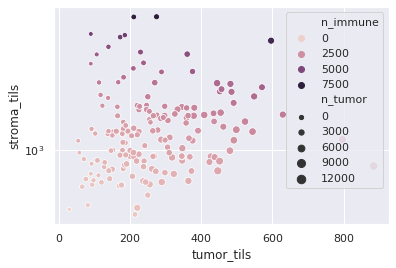

<Figure size 864x720 with 0 Axes>

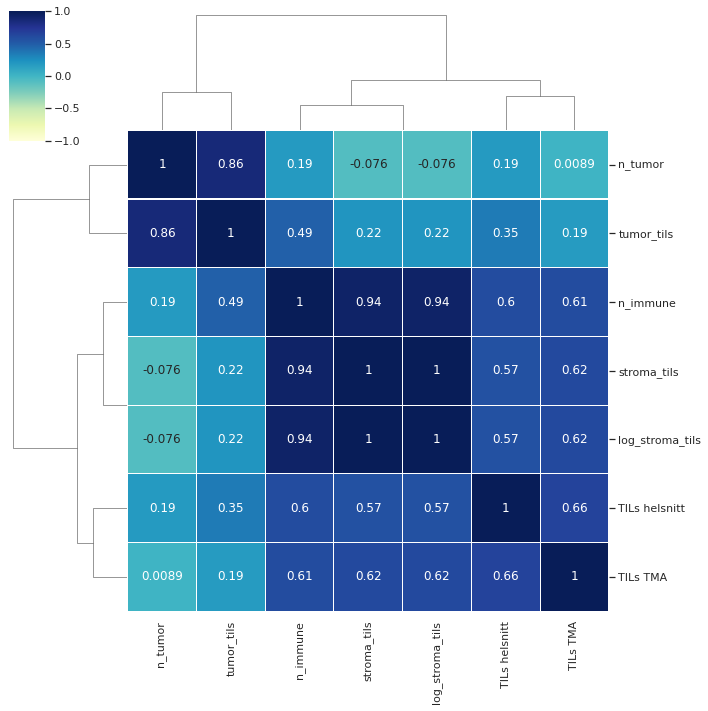

In [768]:
features = [
    'n_tumor',
    'n_immune',
    #'cluster_ratio',
    #'immune_cluster',
    #'tumor_cluster',
    'TILs helsnitt',
    'TILs TMA',
    'tumor_tils',
    'stroma_tils',
    'log_stroma_tils',
]

def correlation(df, features):
    corrmat = df[features].corr(method='spearman')
    plt.figure(figsize=(12,10))
    sns.clustermap(corrmat, vmin=-1, cmap="YlGnBu", linewidth=0.1, annot=True)
    

df_all["log_stroma_tils"] = df_all["stroma_tils"].apply(np.log)
df_treated = df_all[df_all["treated"] == 1]
df_untreated = df_all[df_all["treated"] == 0]
df_DRFI = df_treated[df_treated["DRFI"] == 1]
df_IDFS = df_treated[df_treated["IDFS"] == 1]
df_OS = df_treated[df_treated["OS"] == 1]

correlation(df_all, features)

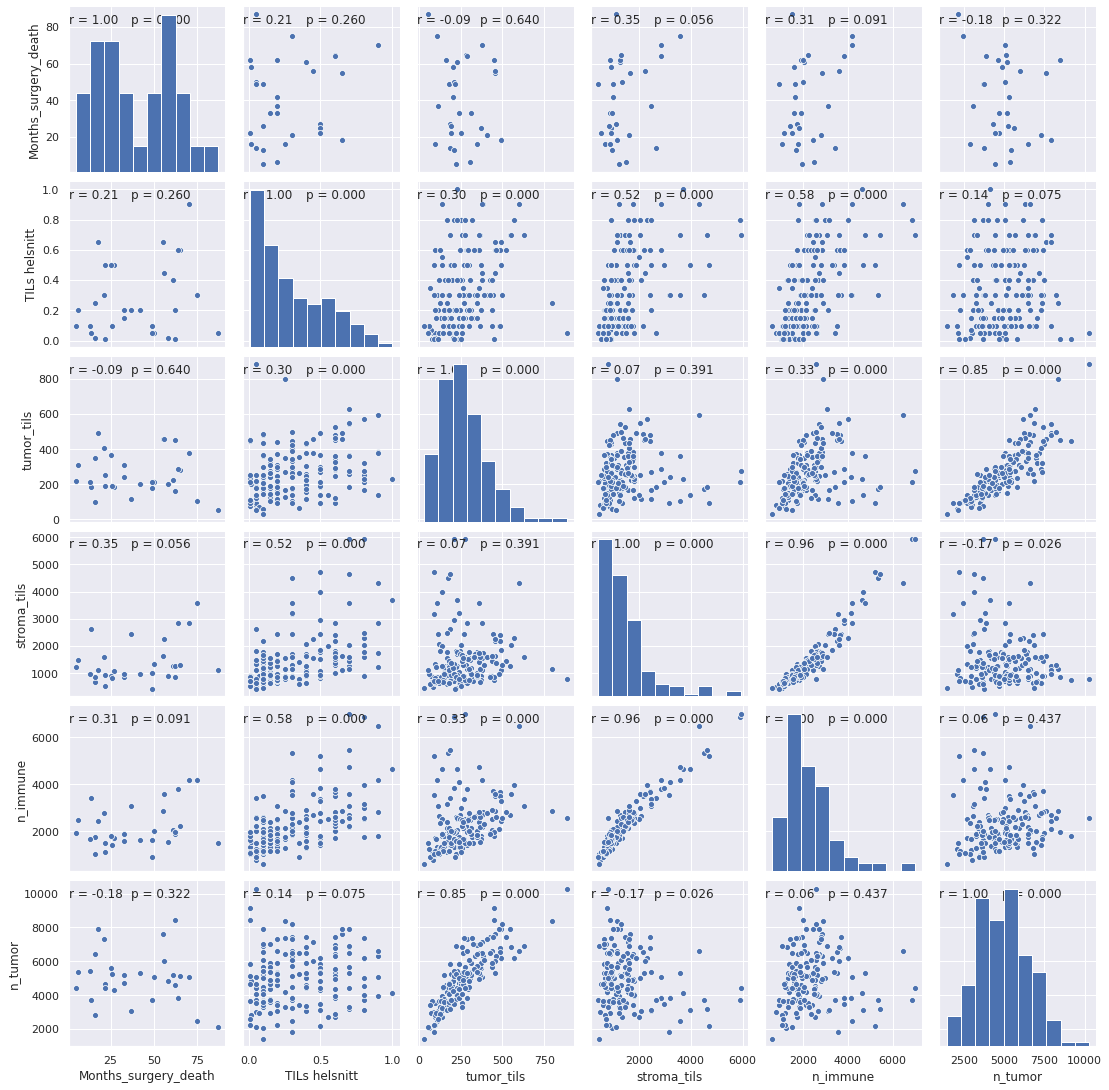

In [796]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

def corrfunc(x, y, **kws):
    (r, p) = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f} ".format(r),
                xy=(.0, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.3f}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)
    
features = [
    'Months_surgery_death',
    'Months_surgery_distant_relapse',
    #'dead',
    'TILs helsnitt',
    'tumor_tils',
    'stroma_tils',
    'n_immune',
    'n_tumor'
]
    
graph = sns.pairplot(df_all[features])
graph.map(corrfunc)
plt.show()

In [ ]:
from skimage.io import imread
print(pat_id)
for patid in df_all["TMAid"].iloc[0:1]:
    plt.figure(figsize=(20,10))
    for n, path in enumerate(_image_path(pat_id), 1):
        plt.imshow(imread(path))

In [ ]:
feature = "high_tils"
df_untreated.groupby("dead")[feature].plot.hist(density=True)
a = df_untreated[df_untreated["dead"] == 1][feature]
b = df_untreated[df_untreated["dead"] == 0][feature]
ttest_ind(a, b, equal_var = False)

In [801]:
import statsmodels.api as sm
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
import seaborn as sn

features = [
    'n_tumor',
    'tumor_tils',
    'Node tatus'
]
classes = ["dead"]
df = df_DRFI[features + classes].dropna()
X = df[features]
y = df[classes]
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)

def _results_to_pandas(summary):
    return pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

cm_list = []
results = []
outer_results = []
for train_val_idx, test_idx in cv_outer.split(X):
    X_train_val, X_test = X.iloc[train_val_idx, :], X.iloc[test_idx, :]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
        
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    for train_idx, val_idx in cv_inner.split(X_train_val):
        x_train, x_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
        y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
        model = sm.Logit(y_train, x_train).fit(disp=False)
        #model = RandomForestClassifier()
        #model.fit(x_train.values, y_train.values.ravel())
        y_pred = np.around(model.predict(x_val))
        cm_list.append(confusion_matrix(y_val, y_pred))
        results.append(_results_to_pandas(model.summary()))
            
            

df_cm = pd.DataFrame(np.sum(cm_list, axis=0))
plt.figure(figsize=(5,5))
sn.heatmap(df_cm, annot=True)
sum(results) / len(results)

KeyError: "['Node tatus'] not in index"